In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 64 # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

In [8]:
num_classes=10

In [9]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [10]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

### Network architecture

In [11]:
dims = (32,32,3)
n_components= 1024


In [12]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [13]:
lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
encoder = models.Sequential()
encoder.add(tf.keras.Input(shape=dims))
### conv1a
name = '1a'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
encoder.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(256, activation=None, name='z'))

In [14]:
classifier = models.Sequential()
classifier.add(tf.keras.Input(shape=(256)))
classifier.add(WeightNormalization(layers.Dense(256, activation=None)))
classifier.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
classifier.add(WeightNormalization(layers.Dense(256, activation=None)))
classifier.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
classifier.add(WeightNormalization(layers.Dense(num_classes, activation=None), name='y_'))

In [15]:
embedder = models.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(WeightNormalization(layers.Dense(256, activation=None)))
embedder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
embedder.add(WeightNormalization(layers.Dense(256, activation=None)))
embedder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
embedder.add(WeightNormalization(layers.Dense(n_components, activation=None), name='z_'))

#### Load weights

In [16]:
dataset = 'cifar10'
load_datestring = "cifar10_64____2020_08_09_22_16_13_299376_baseline_augmented"

In [17]:
from tfumap.paths import MODEL_DIR, ensure_dir

load_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / load_datestring

In [18]:
classifier.load_weights((load_folder / "classifier").as_posix())

W0811 11:24:21.707947 140088282228544 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f67b83ae668> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f67b83aef28>).
W0811 11:24:21.710158 140088282228544 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f67beafa1d0> and <tensorflow.python.keras.layers.advanced_activations.

In [19]:
encoder.load_weights((load_folder / "encoder").as_posix())

W0811 11:24:21.778578 140088282228544 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f67bead4198> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f67bdec95f8>).
W0811 11:24:21.782350 140088282228544 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f67bdec95f8> and <tensorflow.python.keras.layers.adv

W0811 11:24:21.850722 140088282228544 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f67b83d17f0> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f67b83d1b00>).
W0811 11:24:21.853633 140088282228544 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f67b83d1b00> and <tensorflow.python.keras.layers.adv

In [20]:
pretrained_predictions = classifier.predict(encoder.predict(X_test))
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
print('pretrained acc', np.mean(pretrained_predictions == Y_test))

pretrained acc 0.4756


##### look at latent projections

In [21]:
from umap import UMAP

In [22]:
last_layer_class = tf.keras.models.Model(classifier.input,[classifier.get_layer(name="lrelufc2").get_output_at(0)])

In [23]:
last_layer_z = last_layer_class.predict(encoder.predict(X_train))

In [24]:
z_z_ll = UMAP(verbose=True).fit_transform(last_layer_z)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 11:24:36 2020 Finding Nearest Neighbors
Tue Aug 11 11:24:36 2020 Building RP forest with 15 trees
Tue Aug 11 11:24:37 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Tue Aug 11 11:24:47 2020 Finished Nearest Neighbor Search
Tue Aug 11 11:24:50 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 11:25:14 2020 Finished embedding


In [25]:
train_predictions = classifier.predict(
    encoder.predict(X_train, batch_size=128, verbose=True),
    batch_size=128,
    verbose=True,
)

  1/313 [..............................] - ETA: 0s

W0811 11:25:16.328528 140088282228544 callbacks.py:328] Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0056s vs `on_predict_batch_end` time: 0.0124s). Check your callbacks.


313/313 [==============================] - 0s 2ms/step


(array([  10.,   67.,  179.,  344.,  525.,  737.,  819., 1022., 1135.,
        1207., 1264., 1336., 1275., 1303., 1278., 1190., 1164., 1213.,
        1135., 1081.,  973., 1028., 1014.,  937.,  925.,  868.,  890.,
         861.,  839.,  863.,  769.,  822.,  823.,  796.,  819.,  806.,
         752.,  818.,  748.,  798.,  785.,  752.,  704.,  617.,  584.,
         481.,  347.,  196.,   83.,   18.]),
 array([0.13903688, 0.15604228, 0.17304769, 0.19005309, 0.2070585 ,
        0.2240639 , 0.2410693 , 0.2580747 , 0.2750801 , 0.29208553,
        0.3090909 , 0.32609633, 0.34310174, 0.36010712, 0.37711254,
        0.39411795, 0.41112337, 0.42812875, 0.44513416, 0.46213958,
        0.47914496, 0.49615037, 0.51315576, 0.5301612 , 0.5471666 ,
        0.56417197, 0.5811774 , 0.5981828 , 0.6151882 , 0.6321936 ,
        0.649199  , 0.6662044 , 0.68320984, 0.7002152 , 0.7172206 ,
        0.73422605, 0.75123143, 0.7682369 , 0.78524226, 0.80224764,
        0.8192531 , 0.8362585 , 0.85326385, 0.8702693 , 

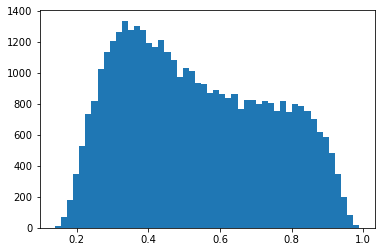

In [26]:
pred_softmax = tf.nn.softmax(train_predictions, axis=1)
confidence = np.max(pred_softmax, axis=1)
plt.hist(confidence, bins = 50)

In [27]:
top_predictions = np.argmax(train_predictions, axis=1)

In [28]:
correctness = top_predictions == Y_train

In [29]:
incorrect_mask = correctness == False

Text(0.5, 1.0, 'incorrect (ground truth)')

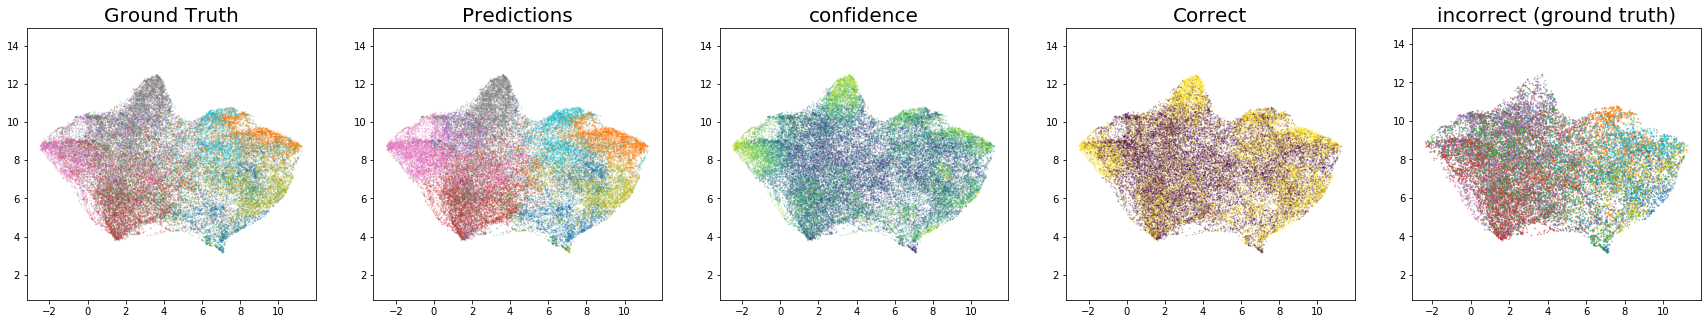

In [30]:
fig, axs = plt.subplots(ncols = 5, figsize=(30 , 5))
ax = axs[0]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=Y_train,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Ground Truth", fontsize=20)

ax = axs[1]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=top_predictions,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Predictions", fontsize=20)

ax = axs[2]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=confidence,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)

ax = axs[3]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=correctness,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Correct", fontsize=20)

ax = axs[4]
sc = ax.scatter(
    z_z_ll[incorrect_mask, 0],
    z_z_ll[incorrect_mask, 1],
    c=Y_train[incorrect_mask],
    cmap="tab10",
    s=0.5,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("incorrect (ground truth)", fontsize=20)

##### Look at only high-confidence predictions

In [31]:
thresh = 0.8
high_confidence_mask = confidence > thresh

In [32]:
z_z_ll_hc = UMAP(verbose=True).fit_transform(last_layer_z[high_confidence_mask])

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 11:25:27 2020 Finding Nearest Neighbors
Tue Aug 11 11:25:27 2020 Building RP forest with 9 trees
Tue Aug 11 11:25:27 2020 parallel NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
Tue Aug 11 11:25:27 2020 Finished Nearest Neighbor Search
Tue Aug 11 11:25:27 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug 11 11:25:43 2020 Finished embedding


Text(0.5, 1.0, 'correct')

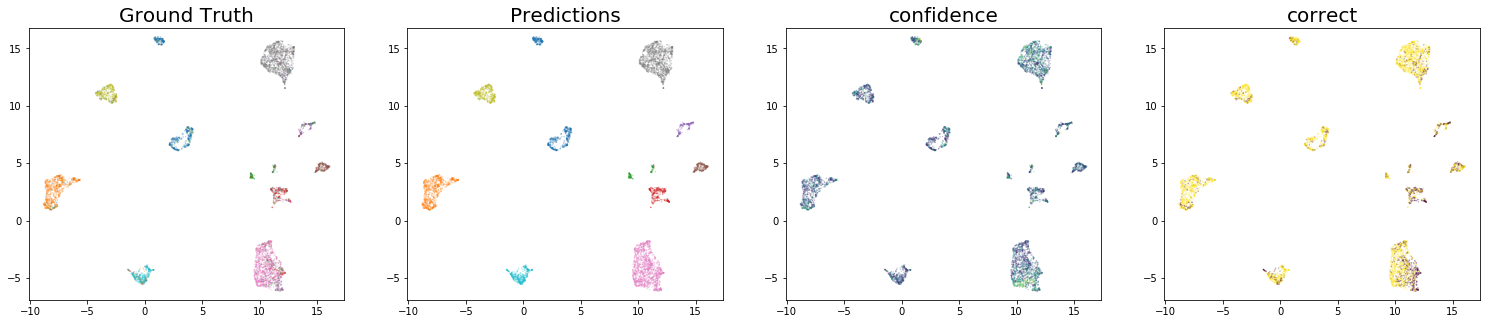

In [33]:
fig, axs = plt.subplots(ncols = 4, figsize=(26 , 5))
ax = axs[0]
sc = ax.scatter(
    z_z_ll_hc[:, 0],
    z_z_ll_hc[:, 1],
    c=Y_train[high_confidence_mask],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Ground Truth", fontsize=20)

ax = axs[1]
sc = ax.scatter(
    z_z_ll_hc[:, 0],
    z_z_ll_hc[:, 1],
    c=top_predictions[high_confidence_mask],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Predictions", fontsize=20)

ax = axs[2]
sc = ax.scatter(
    z_z_ll_hc[:, 0],
    z_z_ll_hc[:, 1],
    c=confidence[high_confidence_mask],
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)

ax = axs[3]
sc = ax.scatter(
    z_z_ll_hc[:, 0],
    z_z_ll_hc[:, 1],
    c=correctness[high_confidence_mask],
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("correct", fontsize=20)


### Prepare model data

In [34]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [35]:
min_dist = 0.0
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9328084>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.790495>)

#### augmentation

In [36]:
import tensorflow_addons as tfa
def augment(image):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.15)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.6, upper=1.4)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.05, seed=None)
    #image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.2, maxval=.2)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (8,8), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image

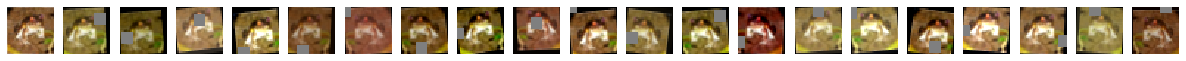

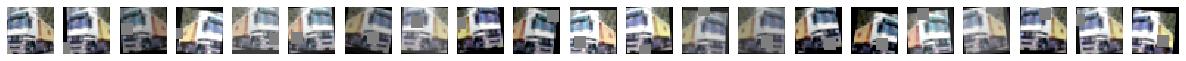

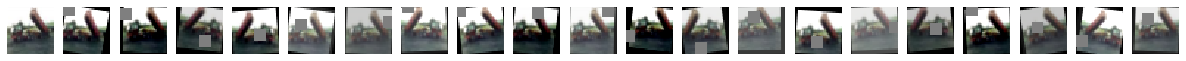

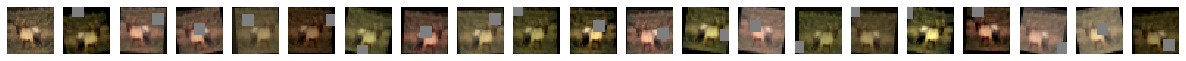

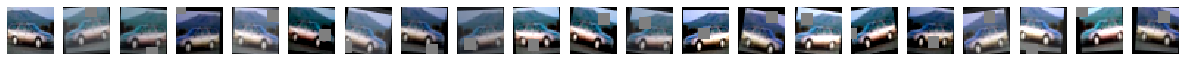

In [37]:
nex = 20
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*1, 1))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i]))
        ax.axis('off')

##### build iterator

In [38]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [39]:
batch_size = 128
batch_size

128

In [40]:
def aug_labeled(image, label):
    return augment(image), label

In [41]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
labeled_dataset = labeled_dataset.shuffle(len(X_labeled))
labeled_dataset = labeled_dataset.repeat()
labeled_dataset = labeled_dataset.map(aug_labeled, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labeled_dataset

<ParallelMapDataset shapes: ((32, 32, 3), (10,)), types: (tf.float32, tf.float32)>

In [42]:
X_train_hc = X_train[high_confidence_mask]

In [43]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train_hc, edge_to), tf.gather(X_train_hc, edge_from)), 0

def aug_edge(images, edge_weight):
    return (augment(images[0]), augment(images[1])), edge_weight

def rearrange_output(label_iter_out, edge_iter_out):
    X_lab, Y_lab = label_iter_out
    (X_to, X_from), edge_prob = edge_iter_out
    return (X_lab, X_to, X_from), {"classifier":Y_lab, "umap": edge_prob}

In [44]:
def prepare_edge_dataset(data, batch_size, labeled_dataset, n_neighbors = 15, n_epochs = 200, max_sample_repeats_per_epoch = 25):
    
    # flatten if needed
    if len(np.shape(data)) > 2:
        data = data.reshape((len(data), np.product(np.shape(data)[1:])))
    
    # compute umap graph
    umap_graph = build_fuzzy_simplicial_set(
        data,
        y=Y_masked,
        n_neighbors=n_neighbors,
    )
    
    # get graph elements
    graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
    )
    
    # set the maximum number of times each edge should be repeated per epoch
    epochs_per_sample = np.clip(
        (weight / np.max(weight)) * max_sample_repeats_per_epoch,
        1,
        max_sample_repeats_per_epoch,
    ).astype("int")
    
    # repeat based on epochs per sample
    edges_to_exp, edges_from_exp = (
            np.repeat(head, epochs_per_sample.astype("int")),
           np.repeat(tail, epochs_per_sample.astype("int")),
    )
    
    # shuffle everything
    shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
    edges_to_exp = edges_to_exp[shuffle_mask]
    edges_from_exp = edges_from_exp[shuffle_mask]
    
    # create iterator
    edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
    edge_iter = edge_iter.shuffle(10000)
    edge_iter = edge_iter.map(gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    edge_iter = edge_iter.map(aug_edge, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    #merge with  labeled iterator
    zipped_ds = tf.data.Dataset.zip((labeled_dataset, edge_iter))
    zipped_ds = zipped_ds.map(rearrange_output, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    zipped_ds = zipped_ds.batch(batch_size, drop_remainder=True)
    
    return zipped_ds

In [45]:
zipped_ds = prepare_edge_dataset(last_layer_z[high_confidence_mask], batch_size, labeled_dataset)

In [46]:
(X_lab, X_to, X_from), test  = next(iter(zipped_ds))
X_lab.shape, X_to.shape, X_from.shape

(TensorShape([128, 32, 32, 3]),
 TensorShape([128, 32, 32, 3]),
 TensorShape([128, 32, 32, 3]))

In [47]:
for i, j in zip(range(100), tqdm(zipped_ds)):
    continue

#### Build network

In [48]:
negative_sample_rate = 5

def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [49]:
from tensorflow.keras.layers import Input

In [50]:
to_x = Input(shape=dims, name = "to_x")
from_x = Input(shape=dims, name = "from_x")
classifier_x = Input(shape=dims, name = "classifier_x")


embedding_to = embedder(encoder(to_x))
embedding_from = embedder(encoder(from_x))
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

predictions = classifier(encoder(classifier_x))
predictions = tf.keras.layers.Lambda(lambda x: x, name='classifier')(predictions)

model = tf.keras.Model(
    inputs=[classifier_x, to_x, from_x],
    outputs={"classifier": predictions, "umap":embedding_to_from},
)

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(0.03, momentum = 0.9),
    loss={
        "classifier": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True),
        "umap": umap_loss(batch_size, negative_sample_rate, _a, _b),
    },
    loss_weights = {
        "classifier": 1.0,
        "umap": 1.0,
    },
    metrics={"classifier":"accuracy"}

)

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_loss', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [53]:
num_batches = np.floor(len(X_train)/batch_size).astype(int)
num_batches

312

In [54]:
from livelossplot import PlotLossesKerasTF

In [55]:
groups = {'acccuracy': ['classifier_accuracy', 'val_classifier_accuracy'], 'loss': ['classifier_loss', 'val_classifier_loss']}
plotlosses = PlotLossesKerasTF(groups=groups)

In [56]:
zipped_ds.cardinality() #/ batch_size

<tf.Tensor: shape=(), dtype=int64, numpy=9479>

In [57]:
zipped_ds.cardinality() / num_batches

<tf.Tensor: shape=(), dtype=float64, numpy=30.381410256410255>

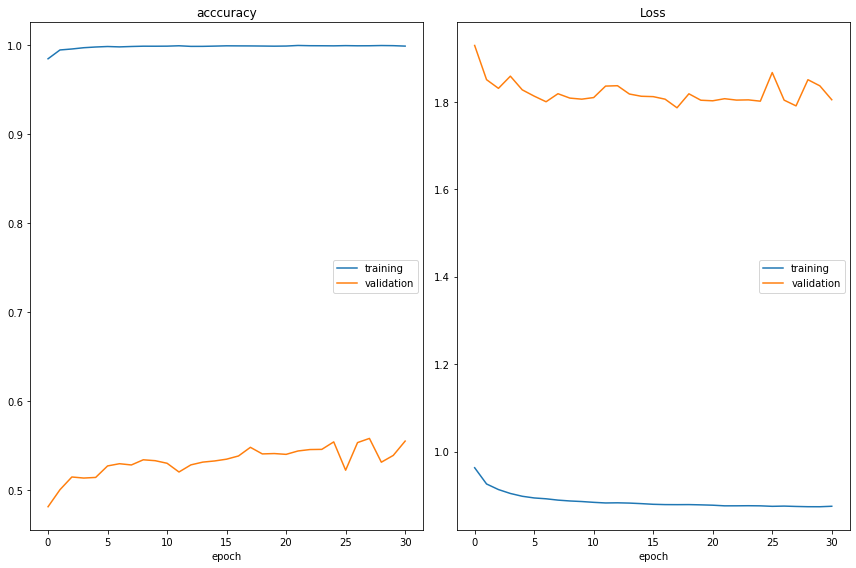

acccuracy
	training         	 (min:    0.984, max:    0.999, cur:    0.999)
	validation       	 (min:    0.481, max:    0.558, cur:    0.555)
Loss
	training         	 (min:    0.874, max:    0.963, cur:    0.875)
	validation       	 (min:    1.786, max:    1.929, cur:    1.805)
119/312 [==========>...................] - 22s 183ms/step - loss: 1.0625 - classifier_loss: 0.8747 - umap_loss: 0.1878 - classifier_accuracy: 0.9986 - val_loss: 1.8048 - val_classifier_loss: 1.8048 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.5552


In [58]:
history = model.fit(
    zipped_ds,
    epochs=100,
    validation_data=(
        (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
        {"classifier": Y_valid_one_hot},
    ),
    callbacks = [early_stopping, plotlosses],
    max_queue_size = 100,
    steps_per_epoch = num_batches,
    #verbose=0
)

In [59]:
pred_test = classifier.predict(encoder.predict(X_test))

In [60]:
np.mean(np.argmax(pred_test, axis = 1) == Y_test)

0.5521

In [61]:
z = embedder.predict(encoder.predict(X_train))

In [62]:
from umap import UMAP

In [63]:
z_z = UMAP(verbose=True).fit_transform(z)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 11:50:27 2020 Finding Nearest Neighbors
Tue Aug 11 11:50:27 2020 Building RP forest with 15 trees
Tue Aug 11 11:50:28 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
Tue Aug 11 11:50:29 2020 Finished Nearest Neighbor Search
Tue Aug 11 11:50:30 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 11:50:58 2020 Finished embedding


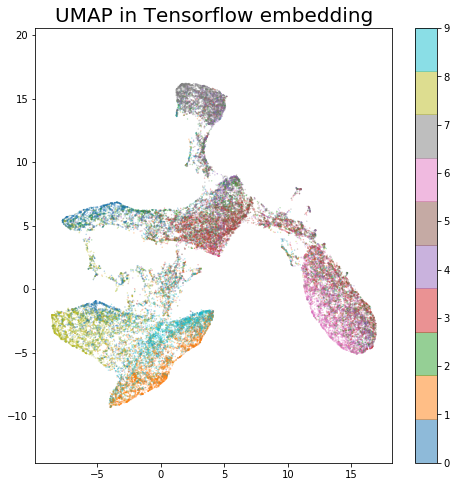

In [64]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_z[:, 0],
    z_z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [65]:
history.history.keys()

dict_keys(['loss', 'classifier_loss', 'umap_loss', 'classifier_accuracy', 'val_loss', 'val_classifier_loss', 'val_umap_loss', 'val_classifier_accuracy'])

Text(0.5, 1.0, 'classifier acc')

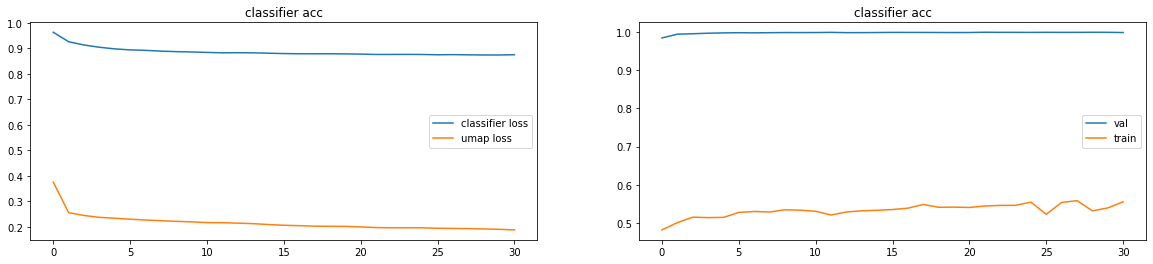

In [66]:
fig, axs = plt.subplots(ncols = 2, figsize=(20,4))

ax = axs[0]
ax.plot(history.history['classifier_loss'], label='classifier loss')
ax.plot(history.history['umap_loss'], label='umap loss')
ax.set_title("classifier acc")
ax.legend()
ax = axs[1]
ax.plot(history.history['classifier_accuracy'], label='val')
ax.plot(history.history['val_classifier_accuracy'], label='train')
ax.legend()
ax.set_title("classifier acc")

In [67]:
### get last layer activation

In [68]:
pred_model = tf.keras.models.Model(classifier.input,[classifier.get_layer(name="lrelufc2").get_output_at(0)])

In [69]:
last_layer_z = pred_model.predict(encoder.predict(X_train))

In [70]:
last_layer_z.shape

(40000, 256)

In [71]:
z_z_ll = UMAP(verbose=True).fit_transform(last_layer_z)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 11:51:08 2020 Finding Nearest Neighbors
Tue Aug 11 11:51:08 2020 Building RP forest with 15 trees
Tue Aug 11 11:51:09 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Aug 11 11:51:10 2020 Finished Nearest Neighbor Search
Tue Aug 11 11:51:10 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 11:51:35 2020 Finished embedding


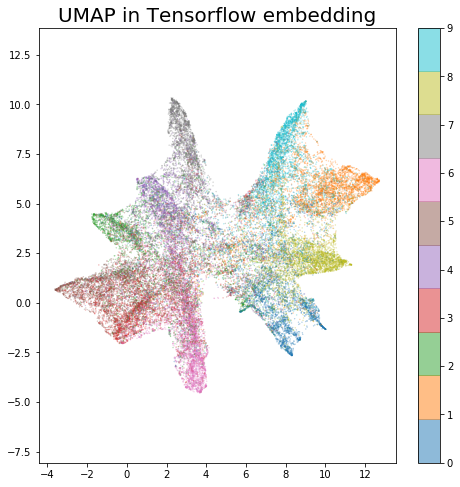

In [72]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [73]:
# plot correct, predictions, accuracy, confidence, incorrect 

In [74]:
from umap import UMAP

In [75]:
last_layer_class = tf.keras.models.Model(classifier.input,[classifier.get_layer(name="lrelufc2").get_output_at(0)])

In [76]:
last_layer_z = last_layer_class.predict(encoder.predict(X_train))

In [77]:
z_z_ll = UMAP(verbose=True).fit_transform(last_layer_z)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 11:51:46 2020 Finding Nearest Neighbors
Tue Aug 11 11:51:46 2020 Building RP forest with 15 trees
Tue Aug 11 11:51:46 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Aug 11 11:51:47 2020 Finished Nearest Neighbor Search
Tue Aug 11 11:51:47 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 11:52:12 2020 Finished embedding


In [78]:
train_predictions = classifier.predict(
    encoder.predict(X_train, batch_size=128, verbose=True),
    batch_size=128,
    verbose=True,
)

  1/313 [..............................] - ETA: 0s

W0811 11:52:13.395061 140088282228544 callbacks.py:328] Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0066s vs `on_predict_batch_end` time: 0.0120s). Check your callbacks.


313/313 [==============================] - 0s 2ms/step


In [79]:
pred_softmax = tf.nn.softmax(train_predictions, axis=1)
confidence = np.max(pred_softmax, axis=1)

In [80]:
top_predictions = np.argmax(train_predictions, axis=1)

In [81]:
correctness = top_predictions == Y_train

In [82]:
incorrect_mask = correctness == False

Text(0.5, 1.0, 'incorrect (ground truth)')

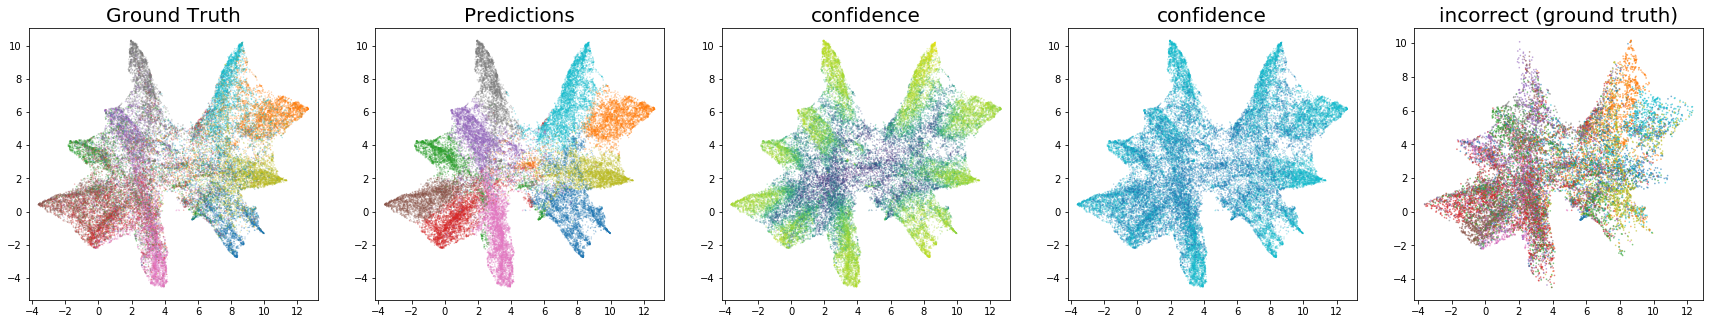

In [83]:
fig, axs = plt.subplots(ncols = 5, figsize=(30 , 5))
ax = axs[0]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=Y_train,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Ground Truth", fontsize=20)

ax = axs[1]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=top_predictions,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Predictions", fontsize=20)

ax = axs[2]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=confidence,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)

ax = axs[3]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=correctness,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)

ax = axs[4]
sc = ax.scatter(
    z_z_ll[incorrect_mask, 0],
    z_z_ll[incorrect_mask, 1],
    c=Y_train[incorrect_mask],
    cmap="tab10",
    s=0.5,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("incorrect (ground truth)", fontsize=20)

(array([  447.,  1850.,  3071.,  3250.,  3206.,  3196.,  3767.,  5542.,
        13393.,  2278.]),
 array([0.13797078, 0.21586822, 0.29376566, 0.3716631 , 0.44956055,
        0.527458  , 0.60535544, 0.6832529 , 0.76115036, 0.8390478 ,
        0.9169452 ], dtype=float32),
 <a list of 10 Patch objects>)

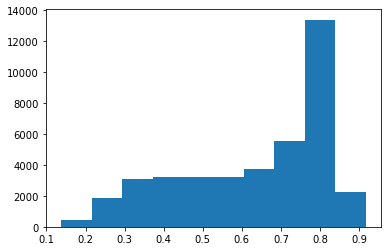

In [84]:
plt.hist(confidence)

(array([  11.,   31.,   79.,  115.,  211.,  245.,  348.,  356.,  399.,
         502.,  570.,  575.,  600.,  672.,  654.,  686.,  647.,  653.,
         651.,  613.,  697.,  607.,  606.,  637.,  659.,  635.,  609.,
         653.,  645.,  654.,  671.,  716.,  758.,  781.,  841.,  940.,
         960., 1062., 1174., 1406., 1644., 2126., 2962., 3658., 3003.,
        1429.,  527.,  235.,   80.,    7.]),
 array([0.13797078, 0.15355027, 0.16912976, 0.18470924, 0.20028873,
        0.21586822, 0.23144771, 0.2470272 , 0.26260668, 0.27818617,
        0.29376566, 0.30934516, 0.32492465, 0.34050414, 0.35608363,
        0.3716631 , 0.3872426 , 0.40282208, 0.41840157, 0.43398106,
        0.44956055, 0.46514004, 0.48071954, 0.49629903, 0.5118785 ,
        0.527458  , 0.5430375 , 0.558617  , 0.57419646, 0.589776  ,
        0.60535544, 0.6209349 , 0.6365144 , 0.6520939 , 0.6676734 ,
        0.6832529 , 0.6988324 , 0.71441185, 0.7299914 , 0.74557084,
        0.76115036, 0.7767298 , 0.7923093 , 0.8078888 , 

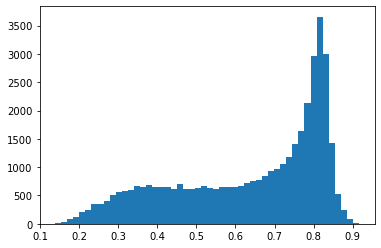

In [85]:
pred_softmax = tf.nn.softmax(train_predictions, axis=1)
confidence = np.max(pred_softmax, axis=1)
plt.hist(confidence, bins = 50)

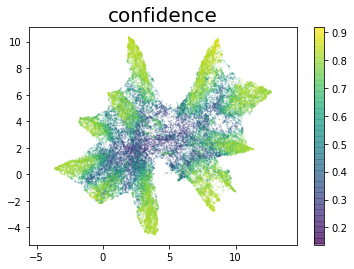

In [86]:
fig, ax = plt.subplots()
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=confidence,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)
plt.colorbar(sc)

In [87]:
thresh = 0.8
high_confidence_mask = confidence > thresh

In [88]:
z_z_ll = UMAP(verbose=True).fit_transform(last_layer_z[high_confidence_mask])

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 11:52:25 2020 Finding Nearest Neighbors
Tue Aug 11 11:52:25 2020 Building RP forest with 10 trees
Tue Aug 11 11:52:26 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Aug 11 11:52:26 2020 Finished Nearest Neighbor Search
Tue Aug 11 11:52:26 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 11:52:35 2020 Finished embedding


In [89]:
Y_train[high_confidence_mask]

array([6, 9, 9, ..., 7, 6, 6], dtype=uint8)

Text(0.5, 1.0, 'confidence')

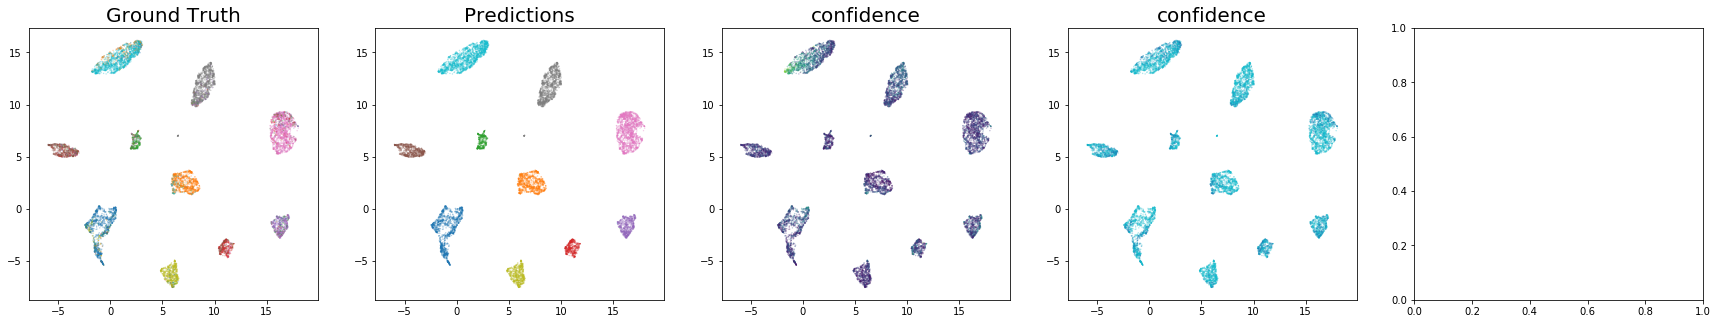

In [90]:
fig, axs = plt.subplots(ncols = 5, figsize=(30 , 5))
ax = axs[0]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=Y_train[high_confidence_mask],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Ground Truth", fontsize=20)

ax = axs[1]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=top_predictions[high_confidence_mask],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Predictions", fontsize=20)

ax = axs[2]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=confidence[high_confidence_mask],
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)

ax = axs[3]
sc = ax.scatter(
    z_z_ll[:, 0],
    z_z_ll[:, 1],
    c=correctness[high_confidence_mask],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("confidence", fontsize=20)


In [91]:
last_layer_z = last_layer_class.predict(encoder.predict(X_train))
train_predictions = classifier.predict(
    encoder.predict(X_train, batch_size=128, verbose=True),
    batch_size=128,
    verbose=True,
)
pred_softmax = tf.nn.softmax(train_predictions, axis=1)
confidence = np.max(pred_softmax, axis=1)
high_confidence_mask = confidence > thresh

  1/313 [..............................] - ETA: 0s

W0811 11:52:46.185546 140088282228544 callbacks.py:328] Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0059s vs `on_predict_batch_end` time: 0.0123s). Check your callbacks.


313/313 [==============================] - 1s 2ms/step


In [92]:
X_train_hc = X_train[high_confidence_mask]

In [93]:
zipped_ds = prepare_edge_dataset(last_layer_z[high_confidence_mask], batch_size, labeled_dataset)

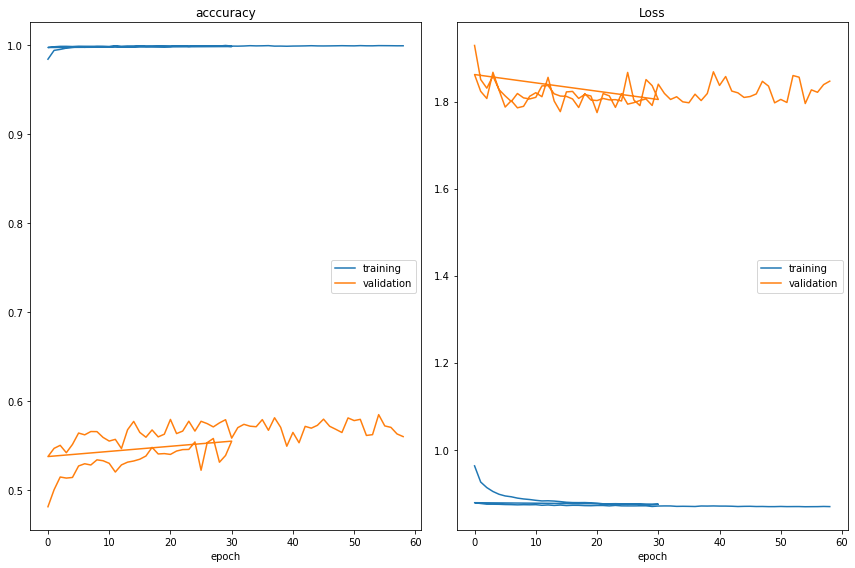

acccuracy
	training         	 (min:    0.984, max:    1.000, cur:    0.999)
	validation       	 (min:    0.481, max:    0.585, cur:    0.560)
Loss
	training         	 (min:    0.869, max:    0.963, cur:    0.869)
	validation       	 (min:    1.775, max:    1.929, cur:    1.847)
241/312 [======================>.......] - 38s 156ms/step - loss: 1.0534 - classifier_loss: 0.8693 - umap_loss: 0.1841 - classifier_accuracy: 0.9995 - val_loss: 1.8469 - val_classifier_loss: 1.8469 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.5603


In [94]:
history = model.fit(
    zipped_ds,
    epochs=100,
    validation_data=(
        (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
        {"classifier": Y_valid_one_hot},
    ),
    callbacks = [early_stopping, plotlosses],
    max_queue_size = 100,
    steps_per_epoch = num_batches,
    #verbose=0
)

In [95]:
last_layer_z = last_layer_class.predict(encoder.predict(X_train))
train_predictions = classifier.predict(
    encoder.predict(X_train, batch_size=128, verbose=True),
    batch_size=128,
    verbose=True,
)
pred_softmax = tf.nn.softmax(train_predictions, axis=1)
confidence = np.max(pred_softmax, axis=1)
high_confidence_mask = confidence > thresh

  1/313 [..............................] - ETA: 0s

W0811 12:39:26.782614 140088282228544 callbacks.py:328] Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0063s vs `on_predict_batch_end` time: 0.0115s). Check your callbacks.


313/313 [==============================] - 1s 2ms/step


In [96]:
X_train_hc = X_train[high_confidence_mask]

In [97]:
zipped_ds = prepare_edge_dataset(last_layer_z[high_confidence_mask], batch_size, labeled_dataset)

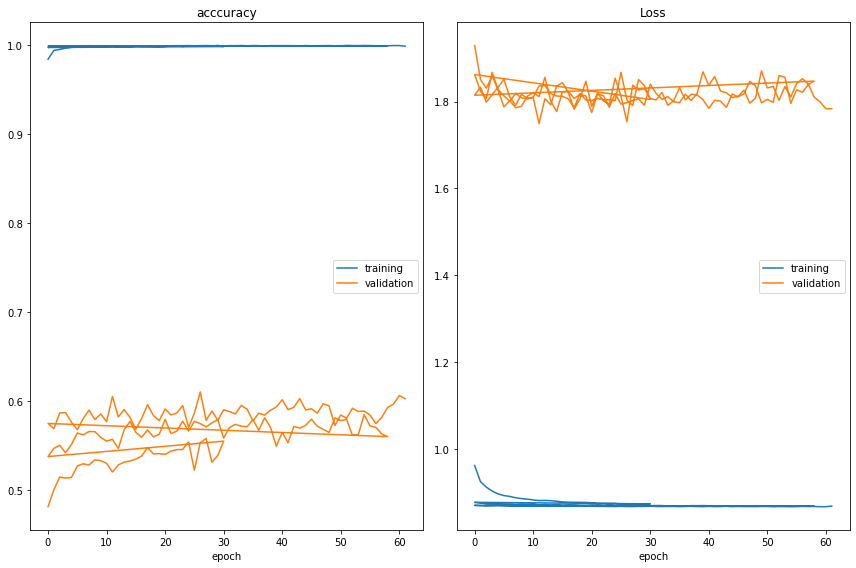

acccuracy
	training         	 (min:    0.984, max:    1.000, cur:    0.999)
	validation       	 (min:    0.481, max:    0.610, cur:    0.603)
Loss
	training         	 (min:    0.868, max:    0.963, cur:    0.870)
	validation       	 (min:    1.749, max:    1.929, cur:    1.784)
312/312 [==============================] - 47s 151ms/step - loss: 1.0594 - classifier_loss: 0.8696 - umap_loss: 0.1899 - classifier_accuracy: 0.9990 - val_loss: 1.7835 - val_classifier_loss: 1.7835 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.6028


In [98]:
history = model.fit(
    zipped_ds,
    epochs=100,
    validation_data=(
        (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
        {"classifier": Y_valid_one_hot},
    ),
    callbacks = [early_stopping, plotlosses],
    max_queue_size = 100,
    steps_per_epoch = num_batches,
    #verbose=0
)

In [99]:
last_layer_z = last_layer_class.predict(encoder.predict(X_train))
train_predictions = classifier.predict(
    encoder.predict(X_train, batch_size=128, verbose=True),
    batch_size=128,
    verbose=True,
)
pred_softmax = tf.nn.softmax(train_predictions, axis=1)
confidence = np.max(pred_softmax, axis=1)
high_confidence_mask = confidence > thresh

  1/313 [..............................] - ETA: 0s

W0811 13:28:41.448787 140088282228544 callbacks.py:328] Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0058s vs `on_predict_batch_end` time: 0.0123s). Check your callbacks.


313/313 [==============================] - 1s 2ms/step


In [100]:
X_train_hc = X_train[high_confidence_mask]

In [101]:
zipped_ds = prepare_edge_dataset(last_layer_z[high_confidence_mask], batch_size, labeled_dataset)

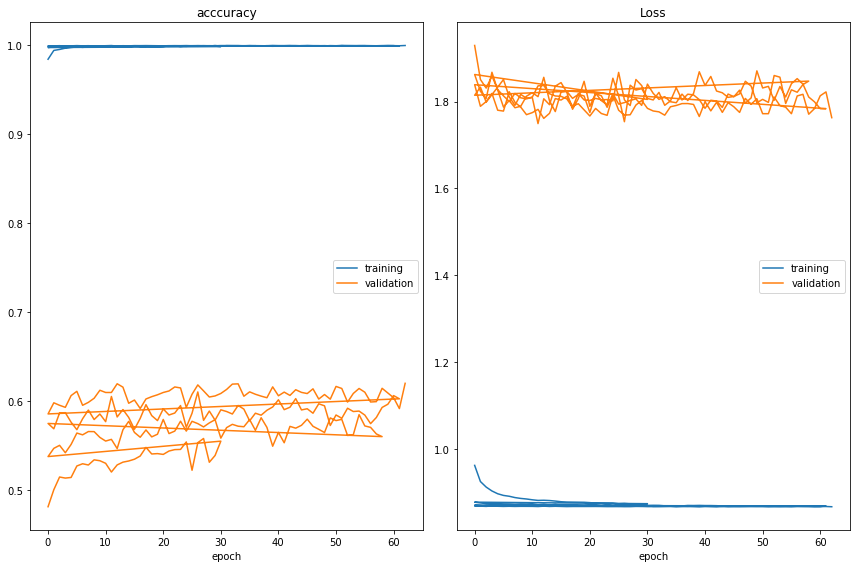

acccuracy
	training         	 (min:    0.984, max:    1.000, cur:    1.000)
	validation       	 (min:    0.481, max:    0.620, cur:    0.620)
Loss
	training         	 (min:    0.868, max:    0.963, cur:    0.868)
	validation       	 (min:    1.749, max:    1.929, cur:    1.763)
312/312 [==============================] - 47s 151ms/step - loss: 1.0610 - classifier_loss: 0.8677 - umap_loss: 0.1932 - classifier_accuracy: 0.9998 - val_loss: 1.7628 - val_classifier_loss: 1.7628 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.6202


In [102]:
history = model.fit(
    zipped_ds,
    epochs=100,
    validation_data=(
        (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
        {"classifier": Y_valid_one_hot},
    ),
    callbacks = [early_stopping, plotlosses],
    max_queue_size = 100,
    steps_per_epoch = num_batches,
    #verbose=0
)

In [103]:
pred_test = classifier.predict(encoder.predict(X_test))

In [104]:
np.mean(np.argmax(pred_test, axis = 1) == Y_test)

0.6174